In [545]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [546]:
data = pd.read_csv('housing.csv')
data.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [547]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [548]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [549]:
data['total_bedrooms'].fillna(data['total_bedrooms'].median(), inplace = True)

In [550]:
data = pd.get_dummies(data, columns = ['ocean_proximity'], prefix = 'ocean')

In [551]:
# finding all the columns with categorical data
cat_features = [col for col in data.columns if col.startswith('ocean')]

# converting them into tensors
cat_values = data[cat_features].values
cat_values = torch.tensor(cat_values, dtype = torch.float32)

In [552]:
# finding all the columns with numerical data (except the house value)
num_features = [col for col in data.columns if data[col].dtype == float and col not in ('median_house_value')]

# standardising them
data[num_features] = (data[num_features] - data[num_features].mean()) / data[num_features].std()

# converting them into tensors
num_values = data[num_features].values
num_values = torch.tensor(num_values, dtype = torch.float32)

In [553]:
house_values = torch.tensor(data['median_house_value'].values, dtype = torch.float32).reshape(-1, 1)

In [554]:
trainX, testX, trainY, testY = train_test_split(torch.cat((num_values, cat_values), dim = 1), house_values, random_state = 0)

In [555]:
input_dim = num_values.shape[1] + cat_values.shape[1]
input_dim

13

# `Define model`

In [556]:
class CustomLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(CustomLoss, self).__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        residual = torch.abs(y_true - y_pred)
        quadratic = torch.clamp(residual, max=self.delta)
        linear = residual - quadratic
        loss = 0.5 * quadratic**2 + self.delta * linear
        return torch.mean(loss)

# class CustomLoss(nn.Module):
#     def __init__(self):
#         super(CustomLoss, self).__init__()

#     def forward(self, y_pred, y_true):
#         residual = y_true - y_pred
#         loss = torch.log(torch.cosh(residual))
#         return torch.mean(loss)

In [557]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128).type(torch.float32)
        self.bn1 = nn.BatchNorm1d(128).type(torch.float32)
        
        self.fc2 = nn.Linear(128, 32).type(torch.float32)
        self.bn2 = nn.BatchNorm1d(32).type(torch.float32)
        
        self.fc3 = nn.Linear(32, 1).type(torch.float32)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

# `Optimization Algorithms `

In [558]:
learning_rate = 0.1
num_epochs = 4000
input_size = num_values.shape[1] + cat_values.shape[1]
output_size = 1
print_interval = 200
batch_size = 256
hidden_size = 8

In [559]:
criterion = CustomLoss()    
def train_model(model, optimizer, epochs, batch_size):
    loss_values = []   

    for param in model.parameters():
        param.requires_grad = True

    for epoch in range(epochs):
        y_pred = model(trainX)
        loss = criterion(y_pred, trainY)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()
        # Save loss value
        loss_values.append(loss.item())

        # Print loss for monitoring
        if (epoch + 1) % print_interval == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_values[-1]:.10f}')

    return loss_values

## `1. SGD`

In [560]:
model = NeuralNetwork(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)
sgd_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 48261.8476562500
Epoch [400/4000], Loss: 45251.5000000000
Epoch [600/4000], Loss: 43812.2304687500
Epoch [800/4000], Loss: 43292.3750000000
Epoch [1000/4000], Loss: 42775.6640625000
Epoch [1200/4000], Loss: 41670.6289062500
Epoch [1400/4000], Loss: 41714.3984375000
Epoch [1600/4000], Loss: 41524.2890625000
Epoch [1800/4000], Loss: 40824.2617187500
Epoch [2000/4000], Loss: 40675.2500000000
Epoch [2200/4000], Loss: 40967.8164062500
Epoch [2400/4000], Loss: 40309.3164062500
Epoch [2600/4000], Loss: 40038.8203125000
Epoch [2800/4000], Loss: 39514.8007812500
Epoch [3000/4000], Loss: 40109.1992187500
Epoch [3200/4000], Loss: 40004.2070312500
Epoch [3400/4000], Loss: 40034.1171875000
Epoch [3600/4000], Loss: 39921.7812500000
Epoch [3800/4000], Loss: 39404.8632812500
Epoch [4000/4000], Loss: 40111.3007812500


In [561]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 35213.34


In [562]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.8360e-01, -1.7266e+00,  5.7852e-01,  ..., -1.1199e-04,
          1.9634e-01,  3.3116e-03],
        [ 2.5775e+00, -1.8833e+00, -4.5282e+00,  ..., -1.9482e-02,
         -1.8019e+00,  3.3511e-01],
        ...,
        [-5.8350e-01,  9.2429e-01, -2.6278e+00,  ...,  6.6910e-03,
         -5.5719e-01,  2.2208e-01],
        [-5.3178e-01,  1.1875e+00, -3.8981e+00,  ...,  3.7697e-04,
          2.0853e-02, -3.3982e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
fc1.bias tensor([ 0.0000e+00, -9.2760e-07,  2.0862e-07,  0.0000e+00, -7.1526e-07,
        -4.1723e-07,  1.1921e-06, -4.1723e-07,  4.7684e-07,  0.0000e+00,
        -7.1526e-07, -7.1526e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         5.0664e-07, -1.0729e-06,  0.0000e+00,  1.7881e-07, -3.5204e-07,
         0.0000e+00,  5.9605e-07,  9.5367e-07,  0.0000e+

## `2. Momentum`

In [564]:
model = NeuralNetwork(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-6, nesterov=True)
momentum_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 42996.1679687500
Epoch [400/4000], Loss: 40777.5351562500
Epoch [600/4000], Loss: 40286.0312500000
Epoch [800/4000], Loss: 39233.8789062500
Epoch [1000/4000], Loss: 38892.6015625000
Epoch [1200/4000], Loss: 38914.0351562500
Epoch [1400/4000], Loss: 38191.9140625000
Epoch [1600/4000], Loss: 39684.7929687500
Epoch [1800/4000], Loss: 37855.8281250000
Epoch [2000/4000], Loss: 38011.9492187500
Epoch [2200/4000], Loss: 37911.6835937500
Epoch [2400/4000], Loss: 38018.4062500000
Epoch [2600/4000], Loss: 38377.6875000000
Epoch [2800/4000], Loss: 37335.6445312500
Epoch [3000/4000], Loss: 38768.7656250000
Epoch [3200/4000], Loss: 38266.1015625000
Epoch [3400/4000], Loss: 36817.0312500000
Epoch [3600/4000], Loss: 37131.2421875000
Epoch [3800/4000], Loss: 37731.0546875000
Epoch [4000/4000], Loss: 37365.3789062500


In [565]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 32624.92


In [566]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1323,  0.5486,  1.1102,  ..., -0.0031, -0.6443,  0.2564],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5570, -0.5268, -0.4913,  ..., -0.1149,  0.0459,  0.9470],
        [ 0.6638, -0.5049, -1.6476,  ..., -0.0147,  0.0030,  0.7392]])
fc1.bias tensor([ 0.0000e+00,  0.0000e+00, -1.6689e-06, -3.8743e-07,  7.9721e-07,
        -8.3447e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.3447e-07,
        -9.5367e-07, -2.2352e-07, -1.4901e-07,  0.0000e+00,  0.0000e+00,
        -2.3842e-07,  7.2760e-12,  0.0000e+00,  1.1921e-07,  7.1526e-07,
         2.9802e-08,  0.0000e+00, -6.5565e-07,  1.4901e-07, -1.7285e-06,
         8.1956e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.2743e-06,
         0.0000e+00, -1.8813e-07,  0.0000e+00, -1.0729e-06, -2.9802e-07,
         3.8370e-07,  0.0000e+00,  

## `3. Adagrad`

In [567]:
model = NeuralNetwork(input_size, hidden_size, output_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
adagrad_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 206841.3906250000
Epoch [400/4000], Loss: 206228.1250000000
Epoch [600/4000], Loss: 205616.0625000000
Epoch [800/4000], Loss: 205003.5468750000
Epoch [1000/4000], Loss: 204391.9375000000
Epoch [1200/4000], Loss: 203776.8125000000
Epoch [1400/4000], Loss: 203172.6875000000
Epoch [1600/4000], Loss: 202550.6406250000
Epoch [1800/4000], Loss: 201944.2500000000
Epoch [2000/4000], Loss: 201329.7656250000
Epoch [2200/4000], Loss: 200723.7343750000
Epoch [2400/4000], Loss: 200110.2343750000
Epoch [2600/4000], Loss: 199498.1875000000
Epoch [2800/4000], Loss: 198896.2968750000
Epoch [3000/4000], Loss: 198279.5312500000
Epoch [3200/4000], Loss: 197669.3437500000
Epoch [3400/4000], Loss: 197050.2187500000
Epoch [3600/4000], Loss: 196450.0156250000
Epoch [3800/4000], Loss: 195821.9687500000
Epoch [4000/4000], Loss: 195234.3906250000


In [568]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 192880.33


In [569]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[ 3.8097e-03, -1.4295e-02, -1.0680e-01,  ..., -3.3878e-06,
         -1.5369e-01,  6.0044e-02],
        [ 2.8850e-01, -2.0855e-01, -1.2268e+00,  ...,  1.5223e-02,
         -5.1647e-02, -6.7814e-02],
        [ 2.4011e-01, -2.8777e-01, -1.5613e+00,  ...,  1.1424e-02,
          3.9056e-02,  1.4091e-02],
        ...,
        [-6.1358e-02,  5.8220e-02, -2.2773e-01,  ..., -7.0744e-05,
          3.1307e-03, -1.0629e-01],
        [ 3.8957e-01, -2.9098e-01, -1.2988e+00,  ...,  9.2237e-03,
         -5.7648e-02, -5.1557e-02],
        [ 2.2662e-01, -2.4705e-01, -1.2973e+00,  ...,  1.0629e-02,
         -2.9791e-02, -6.1882e-02]])
fc1.bias tensor([ 4.6566e-09,  1.4901e-07,  8.3447e-07, -4.4703e-08,  3.8743e-07,
        -3.8743e-07,  6.0536e-08,  3.3528e-08, -6.2585e-07, -4.1723e-07,
         3.2596e-09, -3.2783e-07,  2.9802e-08,  1.1921e-07, -3.5763e-07,
         2.9802e-08,  4.9360e-08,  1.1921e-07,  2.3842e-07, -4.7311e-07,
        -1.7136e-07,  4.9174e-07, -7.0781e-08,  0.0000e+

## `4. RMSprop`

In [570]:
model = NeuralNetwork(input_size, hidden_size, output_size)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
rmsprop_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 170715.9218750000
Epoch [400/4000], Loss: 120387.9062500000
Epoch [600/4000], Loss: 69957.7734375000
Epoch [800/4000], Loss: 50070.2031250000
Epoch [1000/4000], Loss: 47468.6093750000
Epoch [1200/4000], Loss: 46850.1250000000
Epoch [1400/4000], Loss: 47453.5859375000
Epoch [1600/4000], Loss: 45804.8671875000
Epoch [1800/4000], Loss: 45396.5390625000
Epoch [2000/4000], Loss: 45409.6289062500
Epoch [2200/4000], Loss: 45440.1484375000
Epoch [2400/4000], Loss: 45589.2265625000
Epoch [2600/4000], Loss: 45332.1289062500
Epoch [2800/4000], Loss: 45034.6406250000
Epoch [3000/4000], Loss: 44676.7734375000
Epoch [3200/4000], Loss: 45611.0117187500
Epoch [3400/4000], Loss: 45130.2265625000
Epoch [3600/4000], Loss: 44475.1328125000
Epoch [3800/4000], Loss: 45239.9804687500
Epoch [4000/4000], Loss: 45075.2500000000


In [571]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 37346.68


In [572]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
fc1.bias tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  5.9605e-08,  0.0000e+00,  0.0000e+00,
        -1.9073e-06, -1.4305e-05,  0.0000e+00, -2.1935e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -4.2915e-06,
         0.0000e+00,  6.7949e-06,  0.0000e+00, -1.9073e-06,  0.0000e+00,
         0.0000e+00, -2.0862e-07,  9.2983e-06,  1.0014e-05,  5.0068e-06,
         0.0000e+00,  0.0000e+00,  2.1458e-06,  0.0000e+00, -3.4571e-06,
         0.0000e+00, -6.6757e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.8147e-06,
         5.7220e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+

## `5. Adam`

In [573]:
model = NeuralNetwork(input_size, hidden_size,output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
adam_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 172809.9375000000
Epoch [400/4000], Loss: 73033.3671875000
Epoch [600/4000], Loss: 42022.7343750000
Epoch [800/4000], Loss: 41396.6796875000
Epoch [1000/4000], Loss: 40539.9218750000
Epoch [1200/4000], Loss: 40266.3320312500
Epoch [1400/4000], Loss: 39897.9531250000
Epoch [1600/4000], Loss: 39937.2343750000
Epoch [1800/4000], Loss: 39504.4140625000
Epoch [2000/4000], Loss: 39745.6367187500
Epoch [2200/4000], Loss: 39374.7656250000
Epoch [2400/4000], Loss: 39359.3710937500
Epoch [2600/4000], Loss: 39210.7304687500
Epoch [2800/4000], Loss: 39384.8515625000
Epoch [3000/4000], Loss: 38987.2460937500
Epoch [3200/4000], Loss: 38828.9531250000
Epoch [3400/4000], Loss: 38947.8359375000
Epoch [3600/4000], Loss: 38779.0468750000
Epoch [3800/4000], Loss: 38685.4062500000
Epoch [4000/4000], Loss: 38521.8828125000


In [574]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 35457.00


In [575]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-6.4969e+00,  5.2183e+00,  9.2979e+00,  ..., -6.7607e-04,
          2.1714e+00,  1.7156e-01],
        [-2.6055e+00,  5.1914e+00,  2.0265e-01,  ...,  6.0456e-03,
         -3.4814e-01, -1.2532e+00],
        ...,
        [-1.2701e+01,  1.6034e+01, -5.7217e+00,  ..., -2.8607e-03,
          7.1529e-01, -8.0841e-01],
        [-3.4659e+00,  8.3446e+00,  3.6425e+00,  ..., -3.3087e-04,
          2.5468e-01, -5.9443e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
fc1.bias tensor([ 0.0000e+00,  3.5763e-07, -6.5565e-07, -1.7881e-07,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  2.8133e-05, -1.1921e-05,  0.0000e+00,
         1.9670e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  4.7684e-06,  0.0000e+00,  0.0000e+00,  1.3351e-05,
        -5.3406e-05,  6.8545e-06,  0.0000e+00,  0.0000e+

## `6. Adadelta`

In [576]:
model = NeuralNetwork(input_size, hidden_size, output_size)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
adadelta_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 207434.4843750000
Epoch [400/4000], Loss: 207424.2968750000
Epoch [600/4000], Loss: 207320.7968750000
Epoch [800/4000], Loss: 206165.0156250000
Epoch [1000/4000], Loss: 195093.8906250000
Epoch [1200/4000], Loss: 112422.6250000000
Epoch [1400/4000], Loss: 49356.9023437500
Epoch [1600/4000], Loss: 46024.6210937500
Epoch [1800/4000], Loss: 45045.1367187500
Epoch [2000/4000], Loss: 44168.0625000000
Epoch [2200/4000], Loss: 44020.9335937500
Epoch [2400/4000], Loss: 43036.6640625000
Epoch [2600/4000], Loss: 43361.6679687500
Epoch [2800/4000], Loss: 43012.4882812500
Epoch [3000/4000], Loss: 42905.9609375000
Epoch [3200/4000], Loss: 42939.2343750000
Epoch [3400/4000], Loss: 42779.7929687500
Epoch [3600/4000], Loss: 42572.1132812500
Epoch [3800/4000], Loss: 42614.2343750000
Epoch [4000/4000], Loss: 42677.3164062500


In [577]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 34955.14


In [578]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[-3.1711e+02,  2.9902e+02,  3.3565e+02,  ...,  4.3586e-02,
          1.7773e+01, -7.1118e+01],
        [ 7.2565e+01, -7.6925e+01, -7.6112e+00,  ..., -2.5489e-02,
         -2.5065e+01,  4.9995e+01],
        [ 6.3806e+01, -5.5436e+01, -7.5346e+01,  ..., -1.3039e-02,
          2.5416e+00, -1.5177e+01],
        ...,
        [-4.7086e+01,  5.5979e+01, -1.4697e+02,  ...,  1.6536e+01,
          7.1915e+00, -5.4528e+00],
        [ 1.2421e+01, -6.6617e+00, -1.7777e+01,  ..., -3.0607e-01,
         -1.6132e+00, -6.8561e+00],
        [-2.5225e+00,  1.9466e+00, -6.3601e-01,  ...,  4.4482e-03,
          8.9195e-01,  3.4978e+00]])
fc1.bias tensor([ 6.1035e-05, -1.2159e-05,  9.1553e-05, -7.6294e-05,  7.6294e-06,
        -1.4687e-04, -9.5367e-07,  8.3923e-05,  5.7697e-05, -3.7193e-05,
        -2.4414e-04,  7.6294e-06, -2.8610e-06,  0.0000e+00, -3.8147e-06,
         0.0000e+00, -3.7193e-05, -1.5259e-05, -2.1100e-05,  5.8413e-06,
         0.0000e+00,  0.0000e+00, -1.9073e-04,  5.3406e-

## `7. AdaGrad with L1`

In [579]:
model = NeuralNetwork(input_size, hidden_size, output_size)
optimizer = torch.optim.Adagrad(
    model.parameters(), lr=learning_rate, lr_decay=0, weight_decay=0.01)
adagrad_l1_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 206844.3281250000
Epoch [400/4000], Loss: 206235.0937500000
Epoch [600/4000], Loss: 205619.1406250000
Epoch [800/4000], Loss: 205005.2968750000
Epoch [1000/4000], Loss: 204394.2031250000
Epoch [1200/4000], Loss: 203779.3593750000
Epoch [1400/4000], Loss: 203170.8437500000
Epoch [1600/4000], Loss: 202559.0625000000
Epoch [1800/4000], Loss: 201950.6718750000
Epoch [2000/4000], Loss: 201331.8125000000
Epoch [2200/4000], Loss: 200715.5625000000
Epoch [2400/4000], Loss: 200113.0156250000
Epoch [2600/4000], Loss: 199500.7187500000
Epoch [2800/4000], Loss: 198870.9062500000
Epoch [3000/4000], Loss: 198268.3437500000
Epoch [3200/4000], Loss: 197668.7187500000
Epoch [3400/4000], Loss: 197055.0468750000
Epoch [3600/4000], Loss: 196440.5156250000
Epoch [3800/4000], Loss: 195826.1718750000
Epoch [4000/4000], Loss: 195204.8593750000


In [580]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 192927.91


In [581]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[-1.6489e-01,  4.9122e-01,  1.1017e+00,  ...,  2.9816e-05,
          1.2161e-01, -1.8033e-02],
        [ 2.7983e-01, -2.8375e-01,  1.0056e+00,  ..., -2.5100e-03,
         -8.8340e-02, -8.5114e-02],
        [ 1.4480e-01, -2.3843e-01, -6.0854e-01,  ...,  2.1040e-06,
         -1.1206e-01, -1.6573e-01],
        ...,
        [ 1.0689e-01, -1.4866e-01, -6.0147e-01,  ...,  4.5498e-05,
         -1.2481e-01, -9.2202e-02],
        [ 1.0723e-01,  3.1057e-01, -4.2202e+00,  ...,  7.3691e-04,
          1.5338e-01,  1.8259e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
fc1.bias tensor([ 1.1921e-07, -8.3447e-07, -5.2154e-08, -2.3842e-07, -1.1921e-06,
         0.0000e+00, -5.9605e-08, -2.2352e-08,  1.4305e-06,  2.9802e-07,
         1.1921e-07,  9.5367e-07,  3.5763e-07,  4.4703e-08,  9.5367e-07,
         0.0000e+00,  1.2666e-07,  4.7684e-07,  2.6822e-07, -3.5763e-07,
         1.4901e-08,  1.8999e-07,  3.5763e-07,  1.4901e-

## `8. Adadelta with L1`

In [582]:
model = NeuralNetwork(input_size, hidden_size, output_size)
optimizer = torch.optim.Adadelta(
    model.parameters(), lr=learning_rate, weight_decay=0.01)
adadelta_l1_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 207434.0937500000
Epoch [400/4000], Loss: 207424.2968750000
Epoch [600/4000], Loss: 207349.6250000000
Epoch [800/4000], Loss: 206622.3281250000
Epoch [1000/4000], Loss: 199273.3125000000
Epoch [1200/4000], Loss: 133646.2343750000
Epoch [1400/4000], Loss: 54023.7343750000
Epoch [1600/4000], Loss: 47027.0703125000
Epoch [1800/4000], Loss: 45411.9492187500
Epoch [2000/4000], Loss: 44951.9531250000
Epoch [2200/4000], Loss: 44333.9570312500
Epoch [2400/4000], Loss: 43582.1054687500
Epoch [2600/4000], Loss: 42994.3242187500
Epoch [2800/4000], Loss: 42981.3906250000
Epoch [3000/4000], Loss: 42883.4492187500
Epoch [3200/4000], Loss: 42847.8359375000
Epoch [3400/4000], Loss: 42514.6679687500
Epoch [3600/4000], Loss: 42532.9804687500
Epoch [3800/4000], Loss: 42346.3398437500
Epoch [4000/4000], Loss: 41999.6523437500


In [583]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 34284.05


In [584]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[ 1.4095e+01, -1.4339e+01, -3.0554e+01,  ...,  1.4447e-01,
          2.1731e+00,  4.0821e+00],
        [ 8.2705e+01, -6.2398e+01, -5.7634e+00,  ...,  1.0164e-02,
          1.1780e-01, -3.7868e+00],
        [ 2.1916e+00, -1.9108e+00, -4.1072e+01,  ..., -9.5009e-03,
         -1.3187e-01,  3.1171e+01],
        ...,
        [-1.9661e+01,  1.3117e+01, -8.6406e+01,  ..., -2.6682e-02,
          4.3263e+00,  7.2605e+00],
        [ 6.7261e+01, -4.7795e+01,  2.7880e+02,  ..., -2.4308e-02,
         -4.7585e-01, -1.1408e+01],
        [ 2.2103e+01, -1.7332e+01,  9.0071e+01,  ...,  4.3206e+00,
          3.1456e+00, -1.2617e+01]])
fc1.bias tensor([-6.0081e-05,  3.4332e-05,  3.0518e-05, -2.7657e-05, -5.7220e-05,
         1.1444e-05, -4.5776e-05,  5.0545e-05,  4.8637e-05,  3.8147e-06,
        -8.9645e-05, -2.0599e-04,  7.9274e-06, -4.1962e-05, -1.9073e-06,
         7.7724e-05,  7.6294e-06,  3.8147e-05,  2.1696e-05, -6.8665e-05,
        -1.5736e-05,  6.6757e-05, -1.4186e-05,  5.9128e-

## `9. AdamW`

In [585]:
model = NeuralNetwork(input_size, hidden_size, output_size)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate, weight_decay=0.01)
adamw_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 178977.2343750000
Epoch [400/4000], Loss: 113741.1484375000
Epoch [600/4000], Loss: 63003.2382812500
Epoch [800/4000], Loss: 52171.9882812500
Epoch [1000/4000], Loss: 46263.9960937500
Epoch [1200/4000], Loss: 45042.4804687500
Epoch [1400/4000], Loss: 44452.0820312500
Epoch [1600/4000], Loss: 43976.6796875000
Epoch [1800/4000], Loss: 43782.6406250000
Epoch [2000/4000], Loss: 43486.6562500000
Epoch [2200/4000], Loss: 43639.0039062500
Epoch [2400/4000], Loss: 43509.0468750000
Epoch [2600/4000], Loss: 43028.9765625000
Epoch [2800/4000], Loss: 42461.6445312500
Epoch [3000/4000], Loss: 43033.9921875000
Epoch [3200/4000], Loss: 43001.2929687500
Epoch [3400/4000], Loss: 42280.5585937500
Epoch [3600/4000], Loss: 42385.7890625000
Epoch [3800/4000], Loss: 42308.9414062500
Epoch [4000/4000], Loss: 42178.7031250000


In [586]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 37576.79


In [587]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[-1.7417e+01,  1.5205e+01,  1.4962e+01,  ..., -3.9213e-03,
          1.4803e+00,  2.8790e-01],
        [ 2.3850e+00, -8.2522e-01,  2.0655e+01,  ..., -1.5607e-03,
         -9.5639e-01, -2.0436e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.3839e+02, -2.4192e+02,  2.3143e+02,  ..., -3.6926e+00,
         -6.9841e+01,  8.0086e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
fc1.bias tensor([ 6.1989e-06, -1.9073e-06,  0.0000e+00,  0.0000e+00,  8.1062e-06,
        -3.3379e-05, -1.2398e-05,  0.0000e+00,  3.8147e-06,  3.0422e-04,
         7.6294e-06,  0.0000e+00, -1.1921e-06,  0.0000e+00,  0.0000e+00,
         3.0518e-05, -4.7684e-06,  0.0000e+00,  9.5367e-07,  5.7220e-05,
         2.9564e-05,  0.0000e+00,  0.0000e+00,  0.0000e+

## `10. Rprop`

In [588]:
model = NeuralNetwork(input_size, hidden_size, output_size)
optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
rprop_loss = train_model(model, optimizer, num_epochs, batch_size)

Epoch [200/4000], Loss: 41608.7812500000
Epoch [400/4000], Loss: 41139.8242187500
Epoch [600/4000], Loss: 40814.1992187500
Epoch [800/4000], Loss: 40250.2929687500
Epoch [1000/4000], Loss: 39987.3085937500
Epoch [1200/4000], Loss: 39986.3085937500
Epoch [1400/4000], Loss: 39502.0742187500
Epoch [1600/4000], Loss: 39548.2304687500
Epoch [1800/4000], Loss: 39564.4101562500
Epoch [2000/4000], Loss: 39475.7226562500
Epoch [2200/4000], Loss: 39558.9531250000
Epoch [2400/4000], Loss: 39165.4492187500
Epoch [2600/4000], Loss: 39258.8359375000
Epoch [2800/4000], Loss: 39397.5898437500
Epoch [3000/4000], Loss: 39444.6289062500
Epoch [3200/4000], Loss: 39085.2851562500
Epoch [3400/4000], Loss: 39226.9296875000
Epoch [3600/4000], Loss: 39426.1835937500
Epoch [3800/4000], Loss: 39355.8710937500
Epoch [4000/4000], Loss: 39054.3906250000


In [589]:
model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 35516.14


In [590]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

fc1.weight tensor([[ 1.8856e+00, -2.5987e-01, -2.6321e+00,  ...,  8.9882e-04,
          3.5499e+00, -1.8288e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-5.8562e+01,  4.9048e+01, -2.9314e+01,  ...,  9.8896e-01,
          1.3632e+01,  1.4154e+00],
        [ 1.0726e+01, -2.7706e+01,  1.7973e+01,  ..., -1.4895e-02,
         -2.9389e+00,  3.0564e+01],
        [-8.7287e-01,  3.3429e+00, -9.2564e+00,  ..., -1.0825e-01,
          7.7724e-01,  1.0405e+00]])
fc1.bias tensor([-1.7881e-07,  0.0000e+00,  0.0000e+00,  6.5565e-07, -4.0531e-06,
         3.8147e-06,  0.0000e+00, -5.7220e-06,  3.1888e-06, -1.7166e-05,
        -2.9802e-06, -1.0681e-04, -9.5367e-06, -2.9564e-05, -2.8610e-05,
        -1.9073e-05,  0.0000e+00,  0.0000e+00,  1.5259e-05,  0.0000e+00,
         1.4114e-04,  7.4506e-07, -4.7684e-06,  1.5259e-

# `Plotting the loss values`

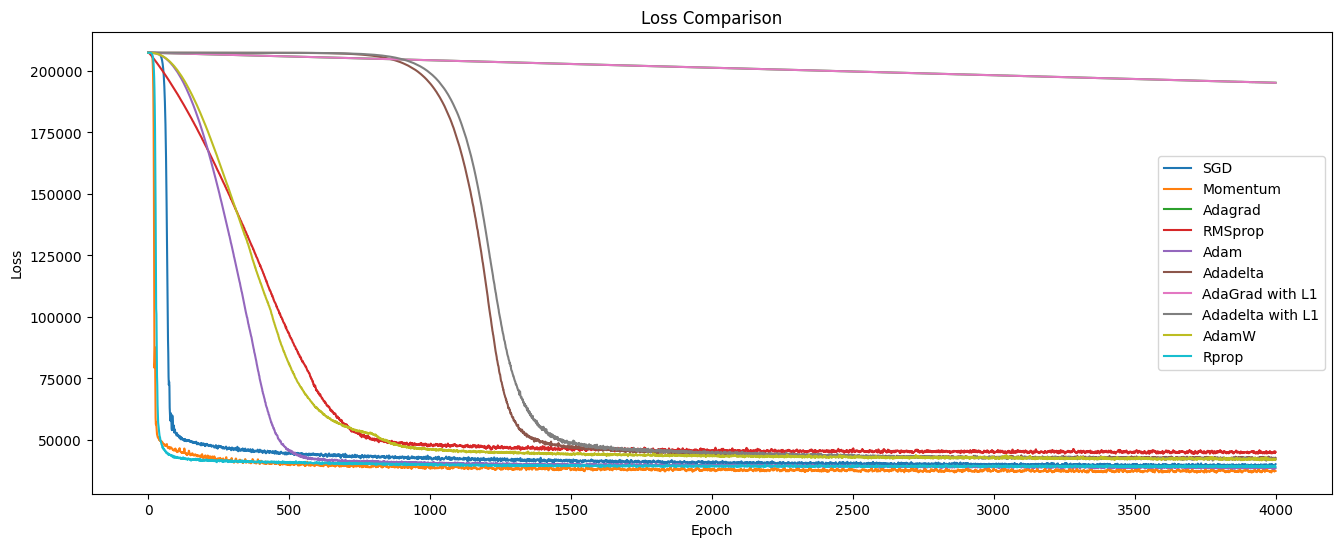

In [593]:
plt.figure(figsize=(16, 6))
plt.plot(sgd_loss, label='SGD')
plt.plot(momentum_loss, label='Momentum')
plt.plot(adagrad_loss, label='Adagrad')
plt.plot(rmsprop_loss, label='RMSprop')
plt.plot(adam_loss, label='Adam')
plt.plot(adadelta_loss, label='Adadelta')
plt.plot(adagrad_l1_loss, label='AdaGrad with L1')
plt.plot(adadelta_l1_loss, label='Adadelta with L1')
plt.plot(adamw_loss, label='AdamW')
plt.plot(rprop_loss, label='Rprop')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.show()